In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras==2.1.2
!pip install tensorflow==1.14.0
!pip install h5py==2.10.0

  Using cached Keras-2.1.2-py2.py3-none-any.whl (304 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires keras<2.9,>=2.8.0rc0, but you have keras 2.1.2 which is incompatible.
  Using cached tensorflow-1.14.0-cp37-cp37m-manylinux1_x86_64.whl (109.3 MB)
  Using cached tensorboard-1.14.0-py3-none-any.whl (3.1 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstalled tensorflow-2.8.0
ERROR: pip's dependency resolver does not curre

In [ ]:


import numpy as np
import tensorflow as tf
from __future__ import print_function
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import activations
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
import pandas as pd
import keras
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras import layers, initializers

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [ ]:
import pickle as pkl

In [ ]:
with open("/content/drive/MyDrive/dataset/train.pkl", "rb") as f:
    x_train, y_train = pkl.load(f)

In [ ]:
with open("/content/drive/MyDrive/dataset/test.pkl", "rb") as f:
    x_test, y_test = pkl.load(f)

In [ ]:
with open("/content/drive/MyDrive/dataset/valid.pkl", "rb") as f:
    x_valid, y_valid = pkl.load(f)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_valid.shape)
print(y_valid.shape)

(2100, 299, 299, 3)
(2100, 3)
(450, 299, 299, 3)
(450, 3)
(450, 299, 299, 3)
(450, 3)


In [ ]:
import tensorflow as tf


In [ ]:
from __future__ import print_function
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import activations
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
import numpy as np
from tensorflow import keras
from tensorflow.keras import optimizers, initializers




In [ ]:
input_image = Input(shape=(299, 299, 3), name='Input')
input_image

<tf.Tensor 'Input:0' shape=(?, 299, 299, 3) dtype=float32>

# Primary Caps

In [ ]:
def Primary_Caps(inputs, name=None):
  temp = Conv2D(filters=64, padding='valid', activation='relu', kernel_size=3)(inputs)
  temp = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones',
                            moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None,
                            gamma_constraint=None)(temp)
  temp = Conv2D(filters=64, padding='valid', activation='relu',kernel_size=3)(temp)
  temp = AveragePooling2D((2, 2))(temp)
  temp = Conv2D(filters=128, padding='valid', activation='relu',kernel_size=3)(temp)
  temp = Conv2D(filters=128, padding='valid', activation='relu',kernel_size=3)(temp)
  
  return temp

In [ ]:
primarycaps = Primary_Caps(input_image)
primarycaps

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


<tf.Tensor 'conv2d_3/Relu:0' shape=(?, 143, 143, 128) dtype=float32>

In [ ]:
primarycaps = Reshape((-1,128), name='Primary_Caps_raw')(primarycaps)
primarycaps

<tf.Tensor 'Primary_Caps_raw/Reshape:0' shape=(?, ?, 128) dtype=float32>

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

# Capsule Layer

## Squash function

In [ ]:
def squash(x, axis=-1, name=None):
  with tf.name_scope(name,default_name="squash"):
    epsilon=1e-7
    squared_norm = K.sum(K.square(x), axis, keepdims=True) + epsilon
    scale = K.sqrt(squared_norm)/(1 + squared_norm)
    return scale * x

## Margin Loss

In [ ]:
def margin_loss(y_true, y_pred):  
  lamb, margin = 0.5, 0.1
  return K.sum((y_true*K.square(K.relu(1-margin-y_pred)) + lamb*(1-y_true)*K.square(K.relu(y_pred-margin))), axis=-1)

CodeCogsEqn (1).gif

## Layer Implementation

In [ ]:
def softmax(x, axis=-1):
  temp = K.exp(x-K.max(x, axis=axis, keepdims=True))
  return temp/K.sum(temp, axis=axis, keepdims=True)

class Capsule(Layer):

  def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
    super(Capsule, self).__init__(**kwargs)
    self.num_capsule = num_capsule
    self.dim_capsule = dim_capsule
    self.routings = routings
    self.share_weights = share_weights
    if activation == 'squash':
        self.activation = squash
    else:
        self.activation = activations.get(activation)

  def build(self, input_shape):
    input_dim_capsule = int(input_shape[-1])
    if self.share_weights:
        self.kernel = self.add_weight(name='Weight_kernel', shape=(1, input_dim_capsule, self.num_capsule*self.dim_capsule), #[1 ,3, 32*8]
                                      initializer=initializers.get('glorot_uniform'))
    else:
        input_num_capsule = int(input_shape[-2])
        self.kernel = self.add_weight(name='Weight_kernel', shape=(input_num_capsule, input_dim_capsule, self.num_capsule*self.dim_capsule),
                                      initializer=initializers.get('glorot_uniform'))

  def call(self, inputs):
    if self.share_weights:
        input_hat = K.conv1d(inputs, self.kernel)
    else:
        input_hat = K.local_conv1d(inputs, self.kernel, [1], [1])

    batch_size = K.shape(inputs)[0]
    input_num_capsule = K.shape(inputs)[1]
    input_hat = K.reshape(input_hat, (batch_size, input_num_capsule, self.num_capsule, self.dim_capsule))
    input_hat = K.permute_dimensions(input_hat, (0, 2, 1, 3))

    b = K.zeros_like(input_hat[:, :, :, 0])
    # shape= [batchsize, nof]
    for i in range(self.routings):
        c = softmax(b, 1)
        if K.backend() == 'theano':
            o = K.sum(o, axis=1)
        o = self.activation(K.batch_dot(c, input_hat, [2, 2]))
        if i < self.routings - 1:
            print(o)
            print(input_hat)
            b += K.batch_dot(o, input_hat, [2, 3])
            if K.backend() == 'theano':
                o = K.sum(o, axis=1)
    return o

  def compute_output_shape(self, input_shape):
    return (None, self.num_capsule, self.dim_capsule)

  def get_config(self):
    config = {
        'num_capsule': self.num_capsule,
        'dim_capsule': self.dim_capsule,
        'routings': self.routings
    }
    base_config = super(Capsule, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [ ]:
batch_size = 10
num_classes = 3
epochs = 30

In [ ]:
with tf.name_scope("Capsule"):
  capsule = Capsule(num_capsule=32, dim_capsule=8, routings=3, share_weights=True)(primarycaps)  
  capsule = Capsule(num_capsule=32, dim_capsule=8, routings=3, share_weights=True)(capsule)   
  capsule = Capsule(num_capsule=num_classes, dim_capsule=16, routings=3, share_weights=True)(capsule)
capsule

Tensor("Capsule/capsule/squash/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("Capsule/capsule/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("Capsule/capsule/squash_1/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("Capsule/capsule/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("Capsule/capsule_1/squash/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("Capsule/capsule_1/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("Capsule/capsule_1/squash_1/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("Capsule/capsule_1/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("Capsule/capsule_2/squash/mul:0", shape=(?, 3, 16), dtype=float32)
Tensor("Capsule/capsule_2/transpose:0", shape=(?, 3, ?, 16), dtype=float32)
Tensor("Capsule/capsule_2/squash_1/mul:0", shape=(?, 3, 16), dtype=float32)
Tensor("Capsule/capsule_2/transpose:0", shape=(?, 3, ?, 16), dtype=float32)


<tf.Tensor 'Capsule/capsule_2/squash_2/mul:0' shape=(?, 3, 16) dtype=float32>

In [ ]:
with tf.name_scope("Prediction"):
  y_pred = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)), name='Prediction')(capsule)
y_pred

<tf.Tensor 'Prediction/Prediction/Sqrt:0' shape=(?, 3) dtype=float32>

In [ ]:
model = Model(inputs=[input_image], outputs=[y_pred])
model.compile(loss=margin_loss, optimizer=optimizers.Adam(lr=0.001) , metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 299, 299, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 297, 297, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 297, 297, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 295, 295, 64)      36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, 147, 147, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 145, 145, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 143, 143, 128)     147584

In [ ]:
class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      self.model.save("/content/drive/MyDrive/Model2/pretrain/architecture/model_caps"+str(epoch)+".hd5")

In [ ]:
# Garbage Collector - use it like gc.collect()
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [ ]:
from collections import defaultdict

def merge_dicts_with_only_lists_as_values(dicts):
  dd = defaultdict(list)
  for d in dicts:
    for key, value in d.items():
      # dict values are always lists for history dicts so extending is fine
      dd[key].extend(value)
  return dd

In [ ]:
class EpochCounter(keras.callbacks.Callback):
  def __init__(self, period, counter_path="/content/drive/MyDrive/Model2/pretrain/epoch.pkl"):
    self.period = period
    self.counter_path = counter_path
    self.clock = 0
    super(EpochCounter, self).__init__()
  def on_epoch_begin(self, epoch, logs=None):
    # save epoch number to disk
    self.clock += 1
    if self.clock % self.period == 1 or self.period == 1:
      pkl.dump(epoch, open(self.counter_path, "wb"))

In [ ]:
class HistoryLogger(keras.callbacks.Callback):
  def __init__(self, period, recovered_history, history_path="/content/drive/MyDrive/Model2/pretrain/history.pkl"):
    self.period = period
    self.recovered_history = recovered_history 
    self.history_path = history_path
    self.clock = 0
    super(HistoryLogger, self).__init__()
  def on_epoch_begin(self, epoch, logs=None):
    self.clock += 1
    if self.clock % self.period == 1 or self.period == 1:
      combined_history = merge_dicts_with_only_lists_as_values([self.recovered_history, self.model.history.history])
      pkl.dump(combined_history, open(self.history_path, "wb"))

In [ ]:
import os
saver = CustomSaver()
if os.path.exists('/content/drive/MyDrive/Model2/pretrain/epoch.pkl'):
  with open('/content/drive/MyDrive/Model2/pretrain/epoch.pkl', 'rb') as f:
    initepoch = pkl.load(f)
else:
  initepoch = 0

if os.path.exists('/content/drive/MyDrive/Model2/pretrain/history.pkl'):
  with open('/content/drive/MyDrive/Model2/pretrain/history.pkl', 'rb') as f:
    his = pkl.load(f)
else:
  his = {}

hislog = HistoryLogger(period=1, recovered_history=his)
eplog = EpochCounter(period=1)
garbage = GarbageCollectorCallback()
history = model.fit(
        [x_train], [y_train],
        batch_size=batch_size,
        epochs=initepoch+5,shuffle=True, 
        callbacks=[saver, garbage, eplog, hislog],
        validation_data=(x_valid, y_valid),
        initial_epoch=initepoch)
history

Train on 2100 samples, validate on 450 samples
Epoch 1/5
2100/2100 [==============================] - 3063s 1s/sample - loss: 0.3634 - acc: 0.3210 - val_loss: 0.3210 - val_acc: 0.3333
Epoch 2/5
2100/2100 [==============================] - 3048s 1s/sample - loss: 0.3206 - acc: 0.3381 - val_loss: 0.3201 - val_acc: 0.3333
Epoch 3/5
2100/2100 [==============================] - 3032s 1s/sample - loss: 0.3204 - acc: 0.3505 - val_loss: 0.3231 - val_acc: 0.3244
Epoch 4/5
2100/2100 [==============================] - 3041s 1s/sample - loss: 0.3185 - acc: 0.3700 - val_loss: 0.3349 - val_acc: 0.3267
Epoch 5/5
2100/2100 [==============================] - 3029s 1s/sample - loss: 0.2958 - acc: 0.4595 - val_loss: 0.2541 - val_acc: 0.5689


In [ ]:
import os
if os.path.exists('/content/drive/MyDrive/Model2/pretrain/epoch.pkl'):
  with open('/content/drive/MyDrive/Model2/pretrain/epoch.pkl', 'rb') as f:
    initepoch = pkl.load(f)
else:
  initepoch = 0
print(initepoch)
model2 = tf.keras.models.load_model('/content/drive/MyDrive/Model2/pretrain/architecture/model_caps'+str(initepoch-1)+'.hd5', custom_objects={'Capsule':Capsule,'margin_loss':margin_loss})
saver = CustomSaver()


if os.path.exists('/content/drive/MyDrive/Model2/pretrain/history.pkl'):
  with open('/content/drive/MyDrive/Model2/pretrain/history.pkl', 'rb') as f:
    his = pkl.load(f)
else:
  his = {}

hislog = HistoryLogger(period=1, recovered_history=his)
eplog = EpochCounter(period=1)
garbage = GarbageCollectorCallback()
history = model2.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=initepoch+6,shuffle=True, 
        callbacks=[saver, garbage, eplog, hislog],
        validation_data = (x_valid, y_valid),
        initial_epoch=initepoch)
history

33
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Tensor("capsule_6/squash/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_6/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_6/squash_1/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_6/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_7/squash/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_7/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_7/squash_1/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_7/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_8/squash/mul:0", shape=(?, 3, 16), dtype=float32)
Tensor("capsule_8/transpose:0", shape

In [ ]:
from tensorflow.keras.models import load_model
model3 = load_model('/content/drive/MyDrive/Model2/pretrain/architecture/model_caps33.hd5', custom_objects={'Capsule':Capsule,'margin_loss':margin_loss})
actual = []
predictions = []
x = 0
y = 0
while x+1<x_test.shape[0]:
  res = model3.predict([x_test[x:x+1]])
  actual.append(np.argmax(y_test[x:x+1]))
  predictions.append(np.argmax(res))
  y+=1
  x+=1

Tensor("capsule_6_1/squash/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_6_1/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_6_1/squash_1/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_6_1/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_7_1/squash/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_7_1/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_7_1/squash_1/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_7_1/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_8_1/squash/mul:0", shape=(?, 3, 16), dtype=float32)
Tensor("capsule_8_1/transpose:0", shape=(?, 3, ?, 16), dtype=float32)
Tensor("capsule_8_1/squash_1/mul:0", shape=(?, 3, 16), dtype=float32)
Tensor("capsule_8_1/transpose:0", shape=(?, 3, ?, 16), dtype=float32)


In [ ]:
actual = np.array(actual)
predictions = np.array(predictions)
print(actual)
print(predictions)

[1 1 0 2 1 2 2 1 0 1 0 2 1 1 0 2 2 0 0 1 0 0 0 0 0 1 0 2 1 0 1 2 0 2 0 0 1
 0 2 1 2 2 2 2 0 1 2 1 2 1 0 1 1 0 0 2 1 2 1 1 2 2 1 1 1 0 2 2 2 0 1 0 2 1
 2 2 2 1 0 0 2 1 1 2 2 0 2 0 0 1 0 0 2 0 1 0 0 1 2 2 1 1 0 1 0 1 0 1 2 0 1
 1 2 1 0 1 0 0 2 0 0 0 0 1 2 2 1 0 0 1 2 2 1 0 2 2 2 1 1 0 1 2 1 0 1 1 2 1
 1 0 2 2 0 0 2 1 2 2 0 2 2 1 0 1 1 1 2 0 2 2 1 1 0 2 0 1 0 2 2 1 1 0 0 1 2
 1 2 1 1 2 2 2 0 0 1 2 2 0 0 0 2 0 0 2 2 1 0 0 2 1 1 0 1 0 1 0 0 1 0 0 1 1
 0 2 0 0 2 1 1 2 0 1 0 0 1 0 0 0 2 1 2 2 0 2 2 1 1 2 2 1 0 1 2 2 0 2 0 0 0
 0 2 0 0 2 0 0 2 2 1 2 2 0 2 2 0 1 1 2 1 1 1 0 1 0 1 0 0 0 1 0 0 2 0 0 0 0
 2 0 1 2 2 2 0 0 1 0 0 2 0 0 0 0 1 1 2 0 2 1 1 0 1 0 0 0 2 2 1 1 1 0 1 1 0
 2 0 2 1 0 0 0 0 1 0 2 0 1 0 1 0 2 1 0 0 2 0 1 1 1 1 1 1 0 2 1 1 0 1 1 1 1
 1 1 0 1 2 1 1 1 0 0 1 1 0 2 0 0 0 1 1 2 1 2 2 1 2 1 1 1 2 0 2 1 0 2 2 0 1
 1 2 2 0 0 0 2 2 0 1 1 0 0 2 1 1 0 2 0 0 0 2 0 2 2 2 0 0 0 1 0 1 2 2 1 1 2
 0 2 2 1 2]
[1 1 0 0 1 2 2 1 2 1 0 2 1 2 0 2 0 0 0 1 2 0 0 0 2 1 0 2 1 2 1 2 0 2 0 0 1
 0 2 1 2 2 2 

In [ ]:
covidimages = []
for i in range(len(predictions)):
  if predictions[i]==0:
    covidimages.append(x_test[i])

In [ ]:
len(covidimages)

150

In [ ]:
with open('covid.pkl', 'wb') as f:
  pkl.dump(covidimages, f)

In [ ]:
indexes = []
for i in range(len(predictions)):
  if predictions[i]==0:
    indexes.append(i)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Covid19', 'Pneumonia', 'Normal']
print(classification_report(actual, predictions, target_names=target_names))

              precision    recall  f1-score   support

     Covid19       0.95      0.86      0.90       165
   Pneumonia       0.93      0.95      0.94       150
      Normal       0.80      0.87      0.84       134

    accuracy                           0.89       449
   macro avg       0.89      0.89      0.89       449
weighted avg       0.90      0.89      0.89       449



In [ ]:
clf_report = classification_report(actual, predictions, target_names=target_names, output_dict=True)
clf_report

{'Covid19': {'f1-score': 0.9015873015873016,
  'precision': 0.9466666666666667,
  'recall': 0.8606060606060606,
  'support': 165},
 'Normal': {'f1-score': 0.8357142857142857,
  'precision': 0.8013698630136986,
  'recall': 0.8731343283582089,
  'support': 134},
 'Pneumonia': {'f1-score': 0.9372937293729374,
  'precision': 0.9281045751633987,
  'recall': 0.9466666666666667,
  'support': 150},
 'accuracy': 0.8930957683741648,
 'macro avg': {'f1-score': 0.8915317722248416,
  'precision': 0.8920470349479213,
  'recall': 0.8934690185436454,
  'support': 449},
 'weighted avg': {'f1-score': 0.8938567448854335,
  'precision': 0.8971030020453127,
  'recall': 0.8930957683741648,
  'support': 449}}

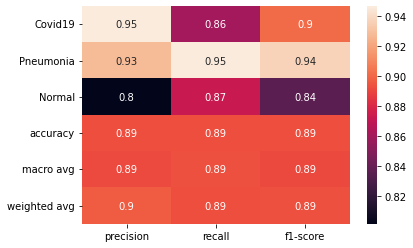

In [ ]:
import seaborn as sns
import pandas as pd
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

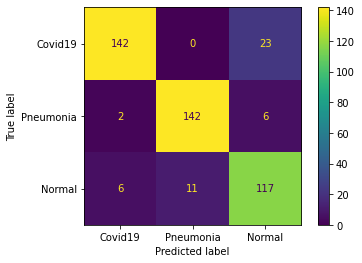

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(actual, predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=target_names)
cmd.plot()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, f1_score
print(f1_score(actual, predictions, average="macro"))
print(precision_score(actual, predictions, average="macro"))
print(recall_score(actual, predictions, average="macro")) 
print(accuracy_score(actual, predictions)) 
print(f1_score(actual, predictions, average="macro"))

0.8915317722248416
0.8920470349479213
0.8934690185436454
0.8930957683741648
0.8915317722248416


In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
print(TP/(TP+FP))
print(np.mean(TN/(TN+FP)))

[0.94666667 0.92810458 0.80136986]
0.9476593987310461


In [ ]:
from tensorflow.keras.models import load_model
model4 = load_model('/content/drive/MyDrive/Model2/pretrain/architecture/model_caps33.hd5', custom_objects={'Capsule':Capsule,'margin_loss':margin_loss})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Tensor("capsule_6/squash/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_6/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_6/squash_1/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_6/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_7/squash/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_7/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_7/squash_1/mul:0", shape=(?, 32, 8), dtype=float32)
Tensor("capsule_7/transpose:0", shape=(?, 32, ?, 8), dtype=float32)
Tensor("capsule_8/squash/mul:0", shape=(?, 3, 16), dtype=float32)
Tensor("capsule_8/transpose:0", shape=(?

In [ ]:
y_test[120]

array([1., 0., 0.], dtype=float32)

In [ ]:
#probability for being of each class
model4.predict(x_test[120:121])

array([[0.90289515, 0.03536674, 0.06929357]], dtype=float32)

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
for i in range(x_test.shape[0]):
  for j in range(x_test.shape[1]):
    for k in range(x_test.shape[2]):
      for l in range(3):
        if masks[i][j][k][l]*255<10:
          x_test[i][j][k][l] =0